# Example 4:  A Kerr nonlinearity in an Ohmic enviroment

This example provides the necessary code to reproduce the calculations from example 3 in [2](https://arxiv.org/abs/2506.22346), where the Hamiltonian is given by

\begin{align}
     H &=\underbrace{\omega_{0} a^{\dagger}a+\frac{\chi}{2} a^{\dagger}a^{\dagger}aa}_{H_S}+ \underbrace{\sum_{k} w_{k} a_{k}^{\dagger} a_{k}}_{H_B} + \underbrace{(a+a^{\dagger})\sum_{k} g_k (a_{k}+a_{k}^{\dagger})}_{H_I}.
\end{align}


We first begin by importing the necessary packages

In [1]:
import qutip as qt 
import numpy as np
from qutip.core.environment import UnderDampedEnvironment
from nmm.redfield import redfield
from nmm import csolve
from scipy import linalg
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import BosonicBath,HEOMSolver,BathExponent
from time import time
import matplotlib.pyplot as plt
# to get cumulant from Interaction to Schrodinger picture
def rotation(data, t, Hsys):
    try:
        rotated = [
            (-1j * Hsys * t[i]).expm()
            * data[i]
            * (1j * Hsys * t[i]).expm()
            for i in range(len(t))
        ]
    except:
        rotated = [
            (-1j * Hsys * t[i]).expm()
            * qt.Qobj(data[i],dims=Hsys.dims)
            * (1j * Hsys * t[i]).expm()
            for i in range(len(t))
        ]
        
    return rotated

We then specify the parameters for the simulation, and construct the Hamiltonian 

In [2]:
N = 10
w0=1
chi = 0.5 # Kerr-nonlinearity
# operators: the annihilation operator of the field
a = qt.destroy(N)

# and we'll also need the following operators in calculation of
# expectation values when visualizing the dynamics
n = qt.num(N)
x = a + a.dag()
p = -1j * (a - a.dag())
H = w0*a.dag()*a +0.5 * chi * a.dag() * a.dag() * a * a
Q = x #coupling operator to the environment


We then construct our initial state which will be a mixture of coherent states

In [3]:
psi0 =(qt.coherent(N, -2.0) - qt.coherent(N, 2.0)) / np.sqrt(2)

rho0=qt.ket2dm(psi0)
rho0/=rho0.tr()

rho0.dims=H.dims

We now prepare our approximated environment

In [4]:
tfit=np.linspace(0,15,2000)
lam = 0.25*np.pi#bath1
bathr=qt.core.environment.OhmicEnvironment(T=0.1*w0,alpha=lam*chi,wc=w0,s=1)
bath1corr,finfo1=bathr.approximate('cf',tfit,tag="bath 1",Ni_max=4,Nr_max=3,maxfev=1e8,target_rmse=None,sigma=1e-5)
print(finfo1['summary'])
options = {'nsteps':150_000, 'store_states':True,'store_ados':True,'rtol':1e-12,'atol':1e-12}

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 3 terms:                    |of the correlation function with 4 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |  vki                   | Parameters|   ckr    |   vkr    |  vki                    
 1         |-2.57e+00 |-1.77e+00 |2.24e-09                | 1         | 6.76e-02 |-4.30e+00 |3.95e+00                 
 2         | 1.38e+00 |-1.25e+00 |4.35e-01                | 2         |-1.06e+00 |-3.77e-01 |1.00e-03                 
 3         | 1.31e+00 |-2.09e+00 |1.03e+00                | 3         |-1.62e+00 |-1.07e+00 |2.71e-02                 
                                                          | 4         |-1.62e+00 |-2.31e+00 |2.90e-01                 
A RMSE of  1.66e-03 w

And we Finally perfom the simulations starting from HEOM

In [5]:
tlist = np.linspace(0,120, 1_000)

start=time()
solver = qt.solver.heom.HEOMSolver(H,[(bath1corr,Q)], max_depth=2, options=options)
# as mentioned below a higher hierarchy is needed, but that would be too slow
result = solver.run(rho0, tlist)
end_heom=time()

10.0%. Run time:   6.87s. Est. time left: 00:00:01:01
20.0%. Run time:  13.70s. Est. time left: 00:00:00:54
30.0%. Run time:  20.45s. Est. time left: 00:00:00:47
40.0%. Run time:  27.18s. Est. time left: 00:00:00:40
50.1%. Run time:  33.89s. Est. time left: 00:00:00:33
60.1%. Run time:  40.53s. Est. time left: 00:00:00:26
70.1%. Run time:  47.21s. Est. time left: 00:00:00:20
80.1%. Run time:  53.96s. Est. time left: 00:00:00:13
90.1%. Run time:  60.62s. Est. time left: 00:00:00:06
100.0%. Run time:  67.25s. Est. time left: 00:00:00:00
Total run time:  67.25s


Then we continue with cumulant, in the first simulation we use numerical integration while on the second one we use the exponents

In [6]:
start2=time()
cum=csolve(Hsys=H,t=tlist,baths=[bathr],Qs=[Q],cython=False,matsubara=False,ls=False,eps=1e-4)
result_cum=cum.evolution(rho0)
result_cum2=rotation(result_cum,tlist,Hsys=H)
end2=time()

Calculating time dependent generators: 100%|██████████| 324/324 [00:03<00:00, 99.24it/s] 
Computing Exponential of Generators . . . .: 1000it [00:19, 51.37it/s]


In [7]:
start3=time()
cum33=csolve(Hsys=H,t=tlist,baths=[bath1corr],Qs=[Q],cython=False,matsubara=True,ls=True)
result_cum33=cum33.evolution(rho0)
result_cum3=rotation(result_cum33,tlist,Hsys=H)
end3=time()

Calculating time dependent generators: 100%|██████████| 324/324 [00:05<00:00, 57.30it/s]
Computing Exponential of Generators . . . .: 1000it [00:19, 50.76it/s]


Finally we perform the simulation of GKLS equation

In [8]:
start4=time()
global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
c_ops=[qt.Qobj((np.sqrt(bathr.power_spectrum(k))*v).data,dims=H.dims) for k, v in global_one.items()]
result_lindblad_global2 = qt.mesolve(H, rho0, tlist, c_ops,options={"rtol":1e-12,"atol":1e-12,"nsteps":25_000})
end4=time()

However, let us take a look at the minimum eigenvalue of the state in time, and norice that HEOM has negative eigenvalues, this is due to a hierarchy that is not high enough and will be fixed if we increase it. To avoid a long simulation, the results will be loaded from an npz, which corresponds to the 4th Hierarchy,  you can simply change the hierarchy above to have the same result

/home/gerardo/.pyenv/versions/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gerardo/.pyenv/versions/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\alpha t$')

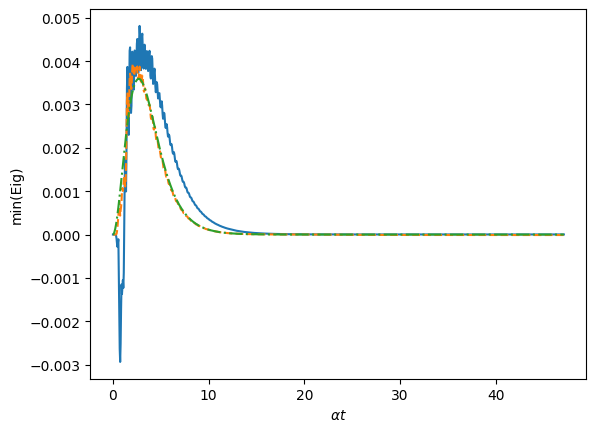

In [9]:
plt.plot(bathr.alpha*tlist,[np.min(i.eigenenergies())for i in result.states])
plt.plot(bathr.alpha*tlist,[np.min(i.eigenenergies())for i in result_cum3],"--")
plt.plot(bathr.alpha*tlist,[np.min(i.eigenenergies())for i in result_lindblad_global2.states],"-.")
plt.ylabel('min(Eig)')
plt.xlabel(r'$\alpha t$')

We load the results of the simulation with higher hierarchy

In [10]:
res=np.load("heom_kerr.npz",allow_pickle=True)
heom=res['heom']


We now obtain the plots from the article

/home/gerardo/Documents/gsuarezr/qutip_gsoc_app/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


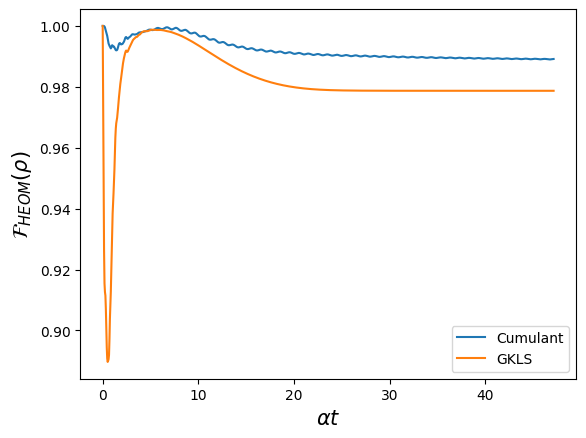

In [11]:
tr=[qt.fidelity(heom[i],result_cum3[i]) for i in range(len(result_cum))]
tr2=[qt.fidelity(heom[i],result_lindblad_global2.states[i]) for i in range(len(result_cum))]

plt.plot(bathr.alpha*tlist,tr,label="Cumulant")
plt.plot(bathr.alpha*tlist,tr2,label="GKLS")

plt.legend()
plt.xlabel(r"$\alpha t$",fontsize=15)
plt.ylabel(r"$\mathcal{F}_{HEOM}(\rho)$",fontsize=15)

plt.show()

In [12]:
def plot_expect_with_variance(op_list, op_title, states,
                                         inset_xlim_start=30, inset_xlim_end=40,
                                         inset_position_size=[0.65, 0.7, 0.3, 0.25]):

    fig, axes = plt.subplots( len(op_list),1, figsize=(9, 5),sharex=True)
    scaled_tlist = bathr.alpha * tlist

    for idx, op in enumerate(op_list):
        main_ax = axes[idx]
        main_ax.tick_params(labelsize=25)
        e_op = qt.expect(op, states)
        v_op = qt.variance(op, states)

        # Main plot
        main_ax.fill_between(
            scaled_tlist, e_op - np.sqrt(v_op), e_op + np.sqrt(v_op), color="orange",
            alpha=0.5
        )
        main_ax.plot(scaled_tlist, e_op)
        main_ax.set_ylabel(op_title[idx],fontsize=25)
        main_ax.set_xlim(scaled_tlist[0], scaled_tlist[-1])
    main_ax.set_xlabel(r"$\alpha t$",fontsize=30)
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.xlim(0,20)
    return fig, axes

/home/gerardo/.pyenv/versions/qutip-dev/lib/python3.13/site-packages/numpy/ma/core.py:2898: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


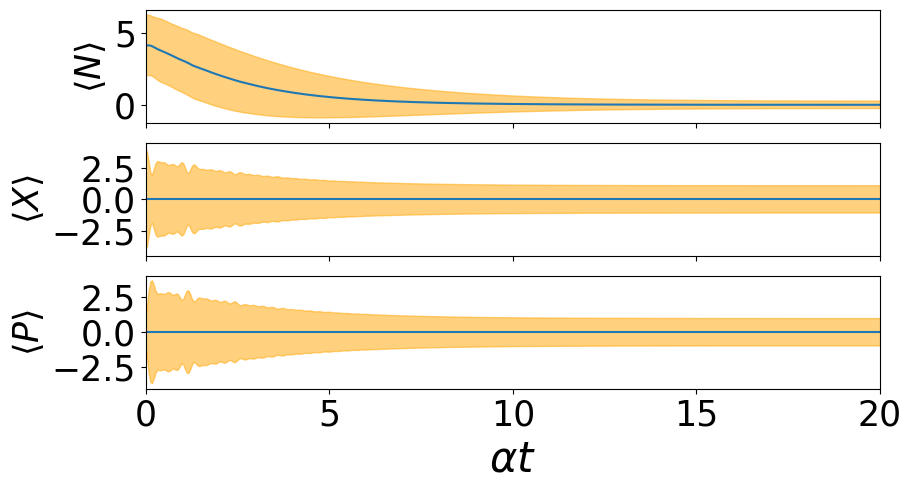

In [13]:
fig1=plot_expect_with_variance([n, x, p], [r"$\langle N \rangle$", r"$\langle X \rangle$", r"$\langle P \rangle$"], result.states)
